# ACS2 in Multiplexer

In [2]:
%matplotlib inline

# General
from __future__ import unicode_literals
import pickle

import numpy as np
import pandas as pd

# Logger
import logging
logging.basicConfig(level=logging.WARN)

# ALCS + custom environments
import sys, os
sys.path.append(os.path.abspath('../../..'))
sys.path.append(os.path.abspath('../../../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList

# Load environments
import gym
import gym_multiplexer

## Multiplexer

In [3]:
mp = gym.make('boolean-multiplexer-20bit-v0')
situation = mp.reset()
mp.render()

[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]

In [4]:
state, reward, done, _ = mp.step(0)

print("New state: {}, reward: {}, is done: {}".format(state, reward, done))

New state: [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0], reward: 0, is done: True


In [5]:
mp.render()

[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]

### Evaluation
Calculate knowledge - check if any of the reliable classifiers gives correct answer.

In [22]:
from gym_multiplexer.utils import get_correct_answer

def calculate_performance(env, population, ctrl_bits=None):
    p1 = env.render()  # state after executing action
    p0 = p1[:-1] + ['0']  # initial state
    correct_answer = get_correct_answer(p0, ctrl_bits)  # true action

    reliable_classifiers = [c for c in population if c.is_reliable()]

    cl_exists = any([1 for cl in reliable_classifiers if
                     cl.predicts_successfully(p0, correct_answer, p1)])

    return {
        'was_correct': cl_exists
    }

## Go agent, go...
Perform experiment for a couple of explore/exploit trials.

In [26]:
def _map_perception(perception):
    return [str(x) for x in perception]

def get_6bit_mp_actors():
    mp = gym.make('boolean-multiplexer-6bit-v0')
    cfg = Configuration(
        mp.env.observation_space.n,
        2,
        perception_mapper_fcn=_map_perception,
        performance_fcn=calculate_performance,
        performance_fcn_params={'ctrl_bits': 2},
        do_ga=True)

    return ACS2(cfg), mp

def get_11bit_mp_actors():
    mp = gym.make('boolean-multiplexer-11bit-v0')
    cfg = Configuration(
        mp.env.observation_space.n,
        2,
        perception_mapper_fcn=_map_perception,
        performance_fcn=calculate_performance,
        performance_fcn_params={'ctrl_bits': 3},
        do_ga=True)

    return ACS2(cfg), mp

def get_20bit_mp_actors():
    mp = gym.make('boolean-multiplexer-20bit-v0')
    cfg = Configuration(
        mp.env.observation_space.n,
        2,
        perception_mapper_fcn=_map_perception,
        performance_fcn=calculate_performance,
        performance_fcn_params={'ctrl_bits': 4},
        do_ga=True)

    return ACS2(cfg), mp

In [29]:
def perform_experiment(agent, env, trials=250_000):
    population, metrics = agent.explore_exploit(env, trials)
    print("Population size: {}".format(metrics[-1]['agent']['population']))
    print("Reliable size: {}".format(metrics[-1]['agent']['reliable']))
    print(metrics[-1])
    
    reliable_classifiers = [c for c in population if c.is_reliable()]
    reliable_classifiers = sorted(reliable_classifiers, key=lambda cl: -cl.q)

    # Print top 10 reliable classifiers
    for cl in reliable_classifiers[:10]:
        print(f"{cl}, q: {cl.q:.2f}, exp: {cl.exp:.2f}")
    
    return population, metrics

Here you will probably want to run these experiments for about 250k trials.

In [32]:
TRIALS = 5_000

In [33]:
# 6bit
p6, m6 = perform_experiment(*get_6bit_mp_actors(), trials=TRIALS)

Population size: 152
Reliable size: 68
{'agent': {'population': 152, 'numerosity': 341, 'reliable': 68, 'fitness': 500.59664913784985, 'trial': 4999, 'steps': 1, 'total_steps': 5000}, 'environment': None, 'performance': {'was_correct': False}}
1###00#-0-######1 @ 0x10faa6eb8, q: 1.00, exp: 228.00
11###1#-1-######1 @ 0x10fb5ccc0, q: 1.00, exp: 200.00
10##1##-1-######1 @ 0x10fb87400, q: 1.00, exp: 205.00
001###0-1-######1 @ 0x10fb6f668, q: 1.00, exp: 228.00
11###0#-0-######1 @ 0x10fbb12e8, q: 1.00, exp: 208.00
01#0##0-0-######1 @ 0x10fb24748, q: 1.00, exp: 212.00
01#1###-1-######1 @ 0x10fa72eb8, q: 1.00, exp: 140.00
10##0##-0-######1 @ 0x10fbd77b8, q: 1.00, exp: 211.00
0#00###-0-######1 @ 0x10fb246d8, q: 1.00, exp: 162.00
001####-1-######1 @ 0x10fae9e10, q: 1.00, exp: 145.00


In [34]:
# 11bit
p11, m11 = perform_experiment(*get_11bit_mp_actors(), trials=TRIALS)

Population size: 1169
Reliable size: 66
{'agent': {'population': 1169, 'numerosity': 1309, 'reliable': 66, 'fitness': 414.1000743258302, 'trial': 4999, 'steps': 1, 'total_steps': 5000}, 'environment': None, 'performance': {'was_correct': False}}
010##1#####0-1-###########1 @ 0x10f802668, q: 1.00, exp: 103.00
#001###1###0-1-###########1 @ 0x1103227b8, q: 1.00, exp: 113.00
00#11#######-1-###########1 @ 0x1101eae48, q: 1.00, exp: 99.00
0#1#0#0####0-0-###########1 @ 0x10f49ee48, q: 1.00, exp: 108.00
100####0###0-0-###########1 @ 0x110114a20, q: 1.00, exp: 95.00
110######0##-0-###########1 @ 0x10f78a6d8, q: 1.00, exp: 74.00
111#######10-1-###########1 @ 0x11026e0f0, q: 1.00, exp: 82.00
0#00#0#####0-0-###########1 @ 0x10f7ec780, q: 1.00, exp: 108.00
101#####1##0-1-###########1 @ 0x110446c88, q: 1.00, exp: 85.00
#10##1###1#0-1-###########1 @ 0x11030e898, q: 1.00, exp: 87.00


In [35]:
# 20bit
p20, m20 = perform_experiment(*get_20bit_mp_actors(), trials=TRIALS)

Population size: 3409
Reliable size: 11
{'agent': {'population': 3409, 'numerosity': 3425, 'reliable': 11, 'fitness': 353.76202602008107, 'trial': 4999, 'steps': 1, 'total_steps': 5000}, 'environment': None, 'performance': {'was_correct': False}}
0100####0###########0-0-####################1 @ 0x110d8c5c0, q: 1.00, exp: 50.00
01#0####0#0#########0-0-####################1 @ 0x10f13e2b0, q: 1.00, exp: 47.00
0111#######0########0-0-####################1 @ 0x110ea3278, q: 1.00, exp: 37.00
100#########00######0-0-####################1 @ 0x110fbbe80, q: 0.99, exp: 39.00
0#11###0###0########0-0-####################1 @ 0x110fbbd30, q: 0.99, exp: 36.00
1001#########0######0-0-####################1 @ 0x110ec0940, q: 0.99, exp: 38.00
#0000#######0########-1-##################### @ 0x10f212be0, q: 0.97, exp: 25.00
##000#######0###0####-1-##################### @ 0x110dd4198, q: 0.92, exp: 18.00
11#0###1####1###1#1#0-1-####################1 @ 0x110f65278, q: 0.91, exp: 9.00
0100####0#######1###0-0-#

In [36]:
def parse_metrics_to_df(metrics):
    def extract_details(row):
        row['trial'] = row['agent']['trial']
        row['numerosity'] = row['agent']['numerosity']
        row['reliable'] = row['agent']['reliable']
        row['was_correct'] = row['performance']['was_correct']
        return row
    
    df = pd.DataFrame(metrics)
    df = df.apply(extract_details, axis=1)
    df.drop(['agent', 'environment', 'performance'], axis=1, inplace=True)
    df.set_index('trial', inplace=True)
    
    return df

In [38]:
# parse metrics to df
df6bit = parse_metrics_to_df(m6)
df11bit = parse_metrics_to_df(m11)
df20bit = parse_metrics_to_df(m20)

df6bit.head()

,numerosity,reliable,was_correct
trial,,,
0,1,0,False
1,1,0,False
2,2,0,False
3,2,0,False
4,3,0,False


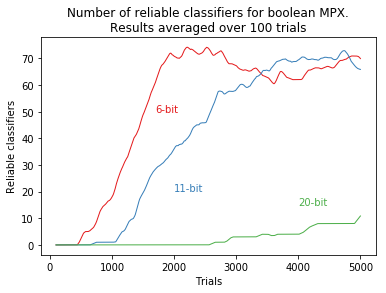

In [49]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

# To avoid Type3 fonts in generated EPS file
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

window=100
TOP_ROWS=TRIALS


fig, ax = plt.subplots()

df6bit['reliable'].head(TOP_ROWS).rolling(window=window).mean().plot(color='#e41a1c', linewidth=1.0, ax=ax)
ax.text(1700, 50, '6-bit', color='#e41a1c')

df11bit['reliable'].head(TOP_ROWS).rolling(window=window).mean().plot(color='#377eb8', linewidth=1.0, ax=ax)
ax.text(2000, 20, '11-bit', color='#377eb8')

df20bit['reliable'].head(TOP_ROWS).rolling(window=window).mean().plot(color='#4daf4a', linewidth=1.0, ax=ax)
ax.text(4000, 15, '20-bit', color='#4daf4a')

ax.set_xlabel('Trials')
ax.set_ylabel('Reliable classifiers')
ax.set_title(f'Number of reliable classifiers for boolean MPX.\nResults averaged over {window} trials')
plt.show()

# plt.savefig('mpx.eps', format='eps', dpi=100)